In [2]:
import pvlib

import pandas as pd

import matplotlib.pyplot as plt

import pvlib.pvsystem as pvsystem


# coordinates = [(47.4, 8.54, 'Zurich-ETZ', 550, 'Etc/GMT-1'),(47.4, 8.54, 'Zurich-ETZ', 550, 'Etc/GMT-1')]

sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [3]:
systems = [({'surface_azimuth': 180, 'surface_tilt':0}),
           ({'surface_azimuth': 180,'surface_tilt':30}),
           ({'surface_azimuth': 180,'surface_tilt':60}),
           ({'surface_azimuth': 180,'surface_tilt':90}),
           ({'surface_azimuth': 180,'surface_tilt':120}),
           ({'surface_azimuth': 180,'surface_tilt':150}),
           ({'surface_azimuth': 180,'surface_tilt':180}),
           ({'surface_azimuth': 180,'surface_tilt':210}),
           ({'surface_azimuth': 180,'surface_tilt':240}),
           ({'surface_azimuth': 180,'surface_tilt':270}),
           ({'surface_azimuth': 180,'surface_tilt':300}),
           ({'surface_azimuth': 180,'surface_tilt':330})]

# system_names = ["testone", "testtwo"]

In [4]:
tmys = []

coordinates = []

for x in range(0, len(systems)):
    coordinates.append((47.4, 8.54, 'Zurich-ETZ', 550, 'Etc/GMT+2'))

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude,map_variables=True)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)

355737.7923229824


355737.79

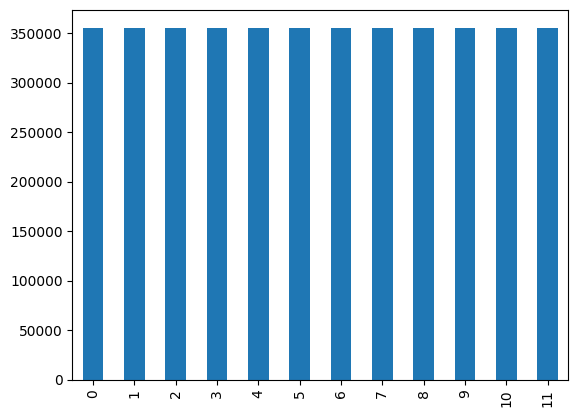

In [5]:
energies = {}

i=0

for system, weather, location in zip(systems, tmys, coordinates):
    latitude, longitude, name, altitude, timezone = location
    # system['surface_tilt'] = latitude
    solpos = pvlib.solarposition.get_solarposition(
        time=weather.index,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        temperature=weather["temp_air"],
        pressure=pvlib.atmosphere.alt2pres(altitude),
    )
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    # aoi = pvlib.irradiance.aoi(
    #     system['surface_tilt'],
    #     system['surface_azimuth'],
    #     solpos["apparent_zenith"],
    #     solpos["azimuth"],
    # )
    aoi = 0
    # total_irradiance = pvlib.irradiance.get_total_irradiance(
    #     system['surface_tilt'],
    #     system['surface_azimuth'],
    #     solpos['apparent_zenith'],
    #     solpos['azimuth'],
    #     weather['dni'],
    #     weather['ghi'],
    #     weather['dhi'],
    #     dni_extra=dni_extra,
    #     model='haydavies',
    # )
    
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        solpos['apparent_zenith'],
        solpos['azimuth'],
        solpos['apparent_zenith'],
        solpos['azimuth'],
        weather['dni'],
        weather['ghi'],
        weather['dhi'],
        dni_extra=dni_extra,
        model='haydavies',
    )

    cell_temperature = pvlib.temperature.sapm_cell(
        total_irradiance['poa_global'],
        weather["temp_air"],
        weather["wind_speed"],
        **temperature_model_parameters,
    )
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
        total_irradiance['poa_direct'],
        total_irradiance['poa_diffuse'],
        am_abs,
        aoi,
        module,
    )
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    annual_energy = ac.sum()
    energies[i] = annual_energy
    i+=1
    # print("run")


energies = pd.Series(energies)


print(energies[0])






energies.plot(kind='bar', rot=90)
355737.79